In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing
from gensim.models import Word2Vec
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
from sklearn.manifold import TSNE
from numpy import dot
from numpy.linalg import norm

# Dataset Description 

The dataset I used for this tutorial is from Kaggle Dataset( https://www.kaggle.com/CooperUnion/cardataset) This cars dataset includes features such as make, model, year, engine, and other properties of the car. We will use these features to generate the word embeddings for each make model and then compare the similarities between different make model. The following dataframe shows the detail information of this dataset.

In [2]:
df = pd.read_csv('data.csv')
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


# Data Preprocessing

Since the purpose of this tutorial is to learn how to generate word embeddings using genism library, I will not do the EDA and feature selection for the word2vec model for the sake of simplicity. 
<br> 
Genism word2Vec requires that a format of list of list for training where every document is contained in a list and every list contains list of tokens of that document. At first, we need to generate a format of list of list for training the make model word embedding. To be more specific, each make model is contained in a list and every list contains list of features of that make model.
To achieve these, we need to do the following data preprocessing steps :
1. Create a new column for Make Model 
2. Generate a format of list of list for each Make Model with the following features: Engine Fuel Type, Transmission Type, Driven_Wheels, Market Category, Vehicle Size and Vehicle Style. 


1. Create a new column for Make Model

In [3]:
df['Maker_Model']= df['Make']+ " " + df['Model']

2. Generate a format of list of list for each Make Model 

In [6]:
# Select features from original dataset to form a new dataframe 
df1 = df[['Engine Fuel Type','Transmission Type','Driven_Wheels','Market Category','Vehicle Size', 'Vehicle Style', 'Maker_Model']]
# For each row, combine all the columns into one column
df2 = df1.apply(lambda x: ','.join(x.astype(str)), axis=1) 
# Store them in the pandas dataframe
df_clean = pd.DataFrame({'clean': df2}) 
# Create the list of list format of the custom corpus for gensim modeling 
sent = [row.split(',') for row in df_clean['clean']]
# show the example of list of list format of the custom corpus for gensim modeling 
sent[:2] 

[['premium unleaded (required)',
  'MANUAL',
  'rear wheel drive',
  'Factory Tuner',
  'Luxury',
  'High-Performance',
  'Compact',
  'Coupe',
  'BMW 1 Series M'],
 ['premium unleaded (required)',
  'MANUAL',
  'rear wheel drive',
  'Luxury',
  'Performance',
  'Compact',
  'Convertible',
  'BMW 1 Series']]

# Genism word2vec Model Training 

Gensim is an open source python library for natural language processing and it was developed and is maintained by the Czech natural language processing researcher Radim Řehůřekand his company RaRe Technologies. Gensim library will enable us to develop word embedding by training our own word2vec models on a custom corpus either with CBOW of skip grams algorithms.

In [8]:
## Train the genisim word2vec model with our own custom corpus
model = Word2Vec(sent, min_count=1,vector_size= 50,workers=3, window =3, sg = 1)

INFO - 15:00:19: collecting all words and their counts
INFO - 15:00:19: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 15:00:19: PROGRESS: at sentence #10000, processed 74060 words, keeping 841 word types
INFO - 15:00:19: collected 977 word types from a corpus of 88129 raw words and 11914 sentences
INFO - 15:00:19: Creating a fresh vocabulary
INFO - 15:00:19: Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 977 unique words (100.0%% of original 977, drops 0)', 'datetime': '2021-11-17T15:00:19.533046', 'gensim': '4.1.2', 'python': '3.9.6 (default, Aug 18 2021, 15:44:49) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19042-SP0', 'event': 'prepare_vocab'}
INFO - 15:00:19: Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 88129 word corpus (100.0%% of original 88129, drops 0)', 'datetime': '2021-11-17T15:00:19.543019', 'gensim': '4.1.2', 'python': '3.9.6 (default, Aug 18 2021, 15:44:49) [MSC v.1916 64 bit (AMD64)]', 'platfor

Let's try to understand the hyperparameter of this model.
1. size: The number of dimensions of the embeddings and the default is 100.
2. window: The maximum distance between a target word and words around the target word. The default window is 5.
3. min_count: The minimum count of words to consider when training the model; words with occurrence less than this count will be ignored. The default for min_count is 5.
4. workers: The number of partitions during training and the default workers is 3. 
5. sg: The training algorithm, either CBOW(0) or skip gram (1). The default training alogrithm is CBOW. 

In [10]:
## We can obtain the word embedding directly from the training model
model.wv['Toyota Camry']

array([ 0.01572528,  0.13599055,  0.03704455, -0.08954529, -0.06445846,
       -0.22404425,  0.00350694,  0.27061936, -0.12228029, -0.06019476,
        0.02229038,  0.01582768,  0.1145827 , -0.03276102, -0.05616296,
        0.18096982,  0.12535837,  0.2903655 , -0.12237998, -0.30806357,
       -0.03151187, -0.03587078,  0.23962602,  0.07983059,  0.17217377,
        0.0085569 , -0.0330934 ,  0.3933856 , -0.0357714 , -0.00306738,
        0.00747878,  0.05875514,  0.04828596, -0.008391  ,  0.09964701,
       -0.15411726,  0.15364073, -0.02498775,  0.0475683 ,  0.07924528,
        0.09397328, -0.03471481, -0.2227231 ,  0.1169392 ,  0.361297  ,
        0.01415497, -0.03182752, -0.17111494,  0.02410394,  0.01501057],
      dtype=float32)

# Compare Similarities 

Now we could even use Word2vec to compute similarity between two make model in the vocabulary by invoking the model.similarity() and passing in the relvevant words. For instance,  model.similarity('Porsche 718 Cayman', 'Nissan Van') This will give us the Euclidian similarity between Porsche 718 Cayman and Nissan Van. 

In [12]:
model.wv.similarity('Porsche 718 Cayman', 'Nissan Van')

0.7528324

In [13]:
model.wv.similarity('Porsche 718 Cayman', 'Mercedes-Benz SLK-Class')

0.89125323

From the above example, we can tell that Porsche 718 Cayman is more similar with Mercedes-Benz SLK-Class than Nissan Van. We also can use the build in function model.most_similar() to get a set of the most similar make models for a given make model.

In [14]:
## Show the most similar vehicles for Mercedes-Benz SLK-Class : Default by eculidean distance 
model.wv.most_similar('Mercedes-Benz SLK-Class')[:5]

[('Maserati Coupe', 0.986635148525238),
 ('BMW Z4', 0.9860998392105103),
 ('Mercedes-Benz SLS AMG GT', 0.9859765768051147),
 ('Audi S3', 0.9854289293289185),
 ('Audi RS 5', 0.9851301908493042)]

In [15]:
## Show the most similar vehicles for Toyota Camry : Default by eculidean distance 
model.wv.most_similar('Toyota Camry')[:5]

[('Chevrolet Cruze', 0.9851263165473938),
 ('Mazda 6', 0.9849883317947388),
 ('Buick Verano', 0.975787341594696),
 ('Suzuki Kizashi', 0.9747454524040222),
 ('Dodge Dart', 0.9746859073638916)]

However, Euclidian similarity cannot work well for the high-dimensional word vectors, This is because Euclidian similarity will increase the number of dimensions increases even if the word embedding stands for different meanings. Alternatively, we can use cosine similarity to measure the similarity between two vectors.  Mathematically, it measures the cosine of the angle between two vectors projected in a multi-dimensional space. Therefore, the cosine similarity captures the angle of the word vectors and not the magnitude. Under cosine similarity, no similarity is expressed as a 90-degree angle while the total similarity of 1 is at 0 degree angle. The following function shows how can we generate the most similar make model based on cosine similarity.

In [16]:
def cosine_distance (model, word,target_list , num) :
    cosine_dict ={}
    word_list = []
    a = model[word]
    for item in target_list :
        if item != word :
            b = model [item]
            cos_sim = dot(a, b)/(norm(a)*norm(b))
            cosine_dict[item] = cos_sim
    dist_sort=sorted(cosine_dict.items(), key=lambda dist: dist[1],reverse = True) ## in Descedning order 
    for item in dist_sort:
        word_list.append((item[0], item[1]))
    return word_list[0:num]

In [20]:
Maker_Model = list(df.Maker_Model.unique()) ## only get the unique Maker_Model_Year
## Show the most similar Mercedes-Benz SLK-Class by cosine distance 
cosine_distance (model.wv,'Mercedes-Benz 500-Class',Maker_Model,5) 

[('Audi A5', 0.9806346),
 ('Mercedes-Benz CLA-Class', 0.9794856),
 ('Acura CL', 0.97860813),
 ('BMW M6', 0.97824746),
 ('Audi S7', 0.97801936)]

In [19]:
Maker_Model

['BMW 1 Series M',
 'BMW 1 Series',
 'Audi 100',
 'FIAT 124 Spider',
 'Mercedes-Benz 190-Class',
 'BMW 2 Series',
 'Audi 200',
 'Chrysler 200',
 'Nissan 200SX',
 'Nissan 240SX',
 'Volvo 240',
 'Mazda 2',
 'BMW 3 Series Gran Turismo',
 'BMW 3 Series',
 'Mercedes-Benz 300-Class',
 'Mitsubishi 3000GT',
 'Chrysler 300',
 'Chrysler 300M',
 'Nissan 300ZX',
 'Mazda 323',
 'Mercedes-Benz 350-Class',
 'Nissan 350Z',
 'Ferrari 360',
 'Nissan 370Z',
 'Mazda 3',
 'BMW 4 Series Gran Coupe',
 'BMW 4 Series',
 'Mercedes-Benz 400-Class',
 'Mercedes-Benz 420-Class',
 'Ferrari 456M',
 'Ferrari 458 Italia',
 'Alfa Romeo 4C',
 'Toyota 4Runner',
 'BMW 5 Series Gran Turismo',
 'BMW 5 Series',
 'Mercedes-Benz 500-Class',
 'FIAT 500e',
 'FIAT 500',
 'FIAT 500L',
 'FIAT 500X',
 'Ferrari 550',
 'Mercedes-Benz 560-Class',
 'McLaren 570S',
 'Ferrari 575M',
 'Maybach 57',
 'Ferrari 599',
 'Mazda 5',
 'BMW 6 Series Gran Coupe',
 'BMW 6 Series',
 'Mercedes-Benz 600-Class',
 'Pontiac 6000',
 'Ferrari 612 Scaglietti',

# T-SNE Plot

It’s hard to visualize the word embedding directly, for they usually has more than 3 dimensions. T-SNE is an useful tool to visualize high-dimensional data by reducing dimensional space while keeping relative pairwise distance between points. It can be said that t-SNE looking for a new data representation where the neighborhood relations are preserved. In this tutorial, I used TSNE package from scikit-learn library. The following code showed how to plot the word embedding with T-SNE plot. 

In [14]:
def display_closestwords_tsnescatterplot(model, word, size):
    
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]

    close_words = model.similar_by_word(word)

    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()


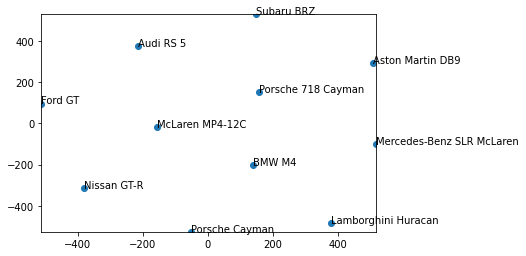

In [15]:
display_closestwords_tsnescatterplot(model, 'Porsche 718 Cayman', 50)

In [20]:
!pip show gensim

Name: gensim
Version: 3.6.0
Summary: Python framework for fast Vector Space Modelling
Home-page: http://radimrehurek.com/gensim
Author: Radim Rehurek
Author-email: me@radimrehurek.com
License: LGPLv2.1
Location: /usr/local/lib/python3.7/dist-packages
Requires: scipy, six, smart-open, numpy
Required-by: 


In [ ]:
!pip show